## Access the new REST-based MODIS web service and perform quality filtering using Python
 
*Date: May 4, 2018*  
*Contact for the ORNL DAAC: uso@daac.ornl.gov*

### Keywords: MODIS, web service, Python, REST

## Overview

This notebook will explore using the Python to access MODIS Land Products through the new (May 2018) REST-based web service hosted by the ORNL DAAC. For a full description and usage examples of the web service, please visit the ORNL DAAC's MODIS microsite:
https://modis.ornl.gov/data/modis_webservice.html

Using the MODIS Web Service users can:

* Retrieve MODIS subsets through command line operations
* Download and integrate subsets directly into client-side workflows
* Download and visualize subsets with customized code 
* ... and much more.

This tutorial will demonstrate how to do the following in Python:

* **dates** and **subset** request examples
* build a time series of MOD11A2 land surface temperature from multiple web service subset requests
* perform quality control filtering based on multiple MODIS qc criteria

## Prerequisites: 

Python 2 or 3
Libraries: requests, json, datetime, pandas, numpy, matplotlib

---  

## Tutorial:

Import required libraries and set request URL and headers:

In [125]:
import requests
import json
import datetime
# import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

url = "https://modis.ornl.gov/rst/api/v1/"
header = {'Accept': 'application/json'} # Use following for a csv response: header = {'Accept': 'text/csv'}

lat = 24
lon = 28

---  

### GET Request: dates
***/api/v1/{product}/dates***

The MODIS Web Service has a ten tile limit per request to ensure responsivity of the service and to avoid time outs. The **dates** function returns a list of available dates for the specified coordinate and MODIS product.

| Parameter          | Description                                                   |
|:-------------------|:--------------------------------------------------------------|
| **product**        | MODIS product code as listed by **products** function         |
| **latitude**       | latitude                                                      |
| **longitude**      | longitude                                                     |


Create a list of dates for MOD11A2 for a coordinate in North Table Mountain Ecological Reserve in California (39.56499, -121.55527) using the **dates** function:

In [126]:
response = requests.get(f'https://modis.ornl.gov/rst/api/v1/MOD13Q1/dates?latitude={lat}&longitude={lon}', headers=header)
dates = json.loads(response.text)['dates']

modis_dates = [i['modis_date'] for i in dates]
calendar_dates = [i['calendar_date'] for i in dates]

The JSON response is passed to the **json.loads()** function as text and the output stored as a python dictionary under the *dates* key. In this case it seems more appropriate to store the dates as a list. Print the first 10 MODIS dates:

In [127]:
start_date, end_data = dates[-2]['modis_date'],  dates[-3]['modis_date']

dates[::-1]

[{'modis_date': 'A2024241', 'calendar_date': '2024-08-28'},
 {'modis_date': 'A2024225', 'calendar_date': '2024-08-12'},
 {'modis_date': 'A2024209', 'calendar_date': '2024-07-27'},
 {'modis_date': 'A2024193', 'calendar_date': '2024-07-11'},
 {'modis_date': 'A2024177', 'calendar_date': '2024-06-25'},
 {'modis_date': 'A2024161', 'calendar_date': '2024-06-09'},
 {'modis_date': 'A2024145', 'calendar_date': '2024-05-24'},
 {'modis_date': 'A2024129', 'calendar_date': '2024-05-08'},
 {'modis_date': 'A2024113', 'calendar_date': '2024-04-22'},
 {'modis_date': 'A2024097', 'calendar_date': '2024-04-06'},
 {'modis_date': 'A2024081', 'calendar_date': '2024-03-21'},
 {'modis_date': 'A2024065', 'calendar_date': '2024-03-05'},
 {'modis_date': 'A2024049', 'calendar_date': '2024-02-18'},
 {'modis_date': 'A2024033', 'calendar_date': '2024-02-02'},
 {'modis_date': 'A2024017', 'calendar_date': '2024-01-17'},
 {'modis_date': 'A2024001', 'calendar_date': '2024-01-01'},
 {'modis_date': 'A2023353', 'calendar_da

In [128]:
response = requests.get('https://modis.ornl.gov/rst/api/v1/MOD13Q1/bands', headers=header)
body = json.loads(response.text)

In [129]:
for band_obj in body['bands']:
    print(band_obj['band'])

250m_16_days_blue_reflectance
250m_16_days_composite_day_of_the_year
250m_16_days_EVI
250m_16_days_MIR_reflectance
250m_16_days_NDVI
250m_16_days_NIR_reflectance
250m_16_days_pixel_reliability
250m_16_days_red_reflectance
250m_16_days_relative_azimuth_angle
250m_16_days_sun_zenith_angle
250m_16_days_view_zenith_angle
250m_16_days_VI_Quality


---

### GET Request: subset
***/api/v1/{product}/dates***

Returns the subset specified by the input parameters in either json or text/csv format. kmAboveBelow and kmLeftRightight indicates the number of kilometers above and below, left and right of the center pixel of the subset; e.g. for a 500-m product (MOD09A1) 10, 10 will result in a subset with a spatial extent covering 20.5- x 20.5-km.  

| Parameter          | Description                                                   |
|:-------------------|:--------------------------------------------------------------|
| **product**        | MODIS product code as listed by **products**                  |
| **latitude**       | latitude                                                      |
| **longitude**      | longitude                                                     |
| **band**           | band ID as listed by **bands**                                |
| **startDate**      | MODIS start date as listed by **dates** ("AYYYYDOY")          |
| **endDate**        | MODIS end date as listed by **dates** ("AYYYYDOY")            |
| **kmAboveBelow**   | number of kilometers to subset above and below center pixel   |
| **kmLeftRight**    | number of kilometers to subset left and right of center pixel |

Submit a request for the MOD11A2 daytime LST 8-day composite for January 1, 2001 for a 1.5- by 1.5-km area near North Table Mountain Ecological Reserve in California (39.56499, -121.55527) using the **subset** function:

In [137]:
start_date, end_data = dates[-2]['modis_date'],  dates[-1]['modis_date']
band = '250m_16_days_EVI'

response = requests.get(f'https://modis.ornl.gov/rst/api/v1/MOD13Q1/subset?latitude={lat}&longitude={lon}&startDate={start_date}&endDate={end_data}&band={band}&kmAboveBelow=70&kmLeftRight=70', headers=header)

subset = json.loads(response.text)
subset

{'xllcorner': '2779413.03',
 'yllcorner': '2603585.77',
 'cellsize': 231.656358264,
 'nrows': 561,
 'ncols': 561,
 'band': '250m_16_days_EVI',
 'units': 'EVI ratio - No units',
 'scale': '0.0001',
 'latitude': 24.0,
 'longitude': 28.0,
 'header': 'https://modisrest.ornl.gov/rst/api/v1/MOD13Q1/subset?latitude=24&longitude=28&startDate=A2024225&endDate=A2024241&band=250m_16_days_EVI&kmAboveBelow=70&kmLeftRight=70',
 'subset': [{'modis_date': 'A2024225',
   'calendar_date': '2024-08-12',
   'band': '250m_16_days_EVI',
   'tile': 'h20v06',
   'proc_date': '2024247142115',
   'data': [780,
    780,
    785,
    759,
    762,
    775,
    745,
    753,
    742,
    741,
    763,
    770,
    752,
    749,
    733,
    738,
    726,
    748,
    766,
    762,
    762,
    756,
    755,
    775,
    767,
    763,
    752,
    756,
    736,
    752,
    727,
    727,
    703,
    714,
    727,
    751,
    698,
    719,
    732,
    729,
    736,
    710,
    745,
    739,
    731,
    709,
   

In [138]:
data = subset['subset'][0]['data']
data = np.array(data).reshape(subset['nrows'], -1)
data_null = data.min()

print(data.max(), data.min(), data.mean(), (data == data_null).sum() / (len(data)))

1064 437 776.2714563057439 0.0017825311942959


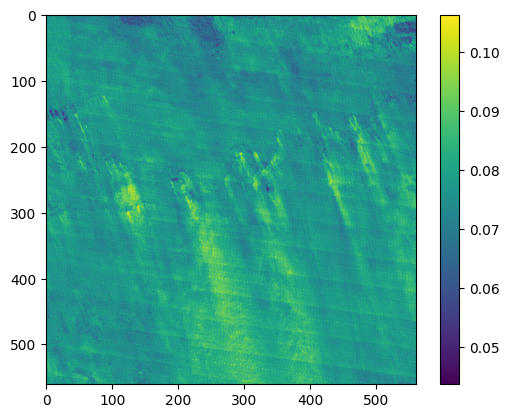

In [141]:
plt.imshow(data * float(subset['scale']))
plt.colorbar()
plt.show()

Again, the JSON response is passed to the **json.loads()** function as text and the output stored as a python dictionary. The 12 dictionary keys correspond to the subset metadata and the subset data itself:

* *band* --- requested band
* *cellsize* --- cell size in meters
* *header* --- request url
* *latitude* --- latitude of center pixel of subset
* *longitude* --- longitude of center pixel of subset
* *ncols* --- number of columns in the subset
* *nrows* --- number of rows in the subset
* *scale* --- scale factor
* *subset* --- subset data; a list of python dictionaries, one per timestep - see below
* *units* --- product data units
* *xllcorner* --- MODIS sinusoidal x-coordinate of the lower left corner of the subset
* *yllcorner* --- MODIS sinusoidal y-coordinate of the lower left corner of the subset

The *subset* key of the dictionary contains the returned data as a list of dictionaries. Each timestep has its own dictionary. Because we requested only January 1, 2001, just one dictionary is returned:

In [ ]:
plt.imshow(data)

Each dictionary in the list has 5 keys: *band*, *data*, *modis_date*, *proc_date*, and *tile*. General information about the MODIS tiling system and processing date can be found at the LP DAAC MODIS page: 
https://lpdaac.usgs.gov/dataset_discovery/modis

The *data* key contains a list of pixel values for your subset. Pixels are listed in row major order, from the top left corner pixel of the subset. Our subset is 1.5- by 1.5-km, or 3 by 3 pixels.  

The list of nine pixel values correspond to the following grid:

||  
|---|---|---|  
| 1 | 2 | 3 |                            
| 4 | 5 | 6 |                      
| 7 | 8 | 9 |             
Our subset:  

||  
|-------|-------|-------|  
| 14354 | 14363 | 14351 |  
| 14299 | 14270 | 14374 |  
| 14294 | 14293 | 14375 |  

---  

Now you're ready to request a time series of data.

## Build time series from multiple requests

Let's request three years of LST data for a 20.5- x 20.5-km area around the same coordinate in North Table Mountain Ecological Reserve (39.56499, -121.55527). Set up the **subset** input parameters:


In [6]:
lat = 39.56499 # Input latitude
lon = -121.55527 # Input longitude
prod = 'MOD11A2' # MODIS product
data_band = 'LST_Day_1km' # Daytime LST band name
qc_band = 'QC_Day' # Daytime QC band name
above_below = 10 # km above/below
left_right = 10 # km left/right

**MOD11A2** is generated in 8-day composites for a total of 46 composite periods per calendar year. 

Take three years of dates beginning with A2001001 : 46 \* 3 = 138 dates

In [7]:
dates = modis_dates[modis_dates.index('A2001001'):modis_dates.index('A2001001') + 137]

We will loop through the list of dates and submit requests for both the **daytime LST** (LST_Day_1km) and **daytime QC layers** (QC_Day). This may take **several minutes**:

In [8]:
# Initialize lists to store the returned LST and QC data
lstdata = []
qcdata = []

# Iterate through the list of dates and submit subset requests for each date:
for dt in dates:
    
    # Join LST request parameters to URL string and submit request
    lstresponse = requests.get("".join([
        url, prod, "/subset?",
        "latitude=", str(lat),
        "&longitude=", str(lon),
        "&band=", data_band,
        "&startDate=", dt,
        "&endDate=", dt,
        "&kmAboveBelow=", str(above_below),
        "&kmLeftRight=", str(left_right)
    ]), headers=header)

    # Append subset data to lstdata
    lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )
        
    # Join QC request parameters to URL string and submit request
    qcresponse = requests.get("".join([
        url, prod, "/subset?",
        "latitude=", str(lat),
        "&longitude=", str(lon),
        "&band=", qc_band,
        "&startDate=", dt,
        "&endDate=", dt,
        "&kmAboveBelow=", str(above_below),
        "&kmLeftRight=", str(left_right)
    ]), headers=header)
    
    # Append qc data to qcdata
    qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )

We are left with two lists of lists containing the LST and QC data values for each step in the time series. Let's convert to **pandas** data frames to make the data more manageable. Rows are timesteps and columns are pixels:

In [9]:
# Convert to real dates
dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

lstdata = pd.DataFrame(lstdata, index=dates)
qcdata = pd.DataFrame(qcdata, index=dates)

Now that we have the LST and QC time series for our subset area, we can perform the quality filtering.

### Evaluate QC data

In order to filter the pixels with questionable quality from our LST time series, we need to understand the QC bit layer. We will do this by building a table of all possible QC integer values and the associated QC bit definitions.

Let's start by getting the unique values from the QC data:

In [10]:
qcvals = pd.unique(qcdata.values.ravel())
qcvals

array([  0,  65,  17,  81,  97,   2, 145], dtype=int64)

**MOD11A2** uses 8-bit unsigned integers to indicate the quality of each pixel. See the [MOD11A2](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod11a2_v006) page of the [MODIS Product Table](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table) for additional resources.

Build a table describing the bits for all possible QC 8-bit integer values (0-255):

In [11]:
# Create empty list to store QC bit information
QC_Data = []

# Iterate through the list of 8-bit integers and populate QC table with bit definitions 
for integer in range(0, 256, 1):
    bits = list(map(int, list("{0:b}".format(integer).zfill(8))))
    
    # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
    # Mandatory_QA bits description
    if (bits[6] == 0 and bits[7] == 0):
        Mandatory_QA = 'LST GOOD'
    if (bits[6] == 0 and bits[7] == 1):
        Mandatory_QA = 'LST Produced,Other Quality'
    if (bits[6] == 1 and bits[7] == 0):
        Mandatory_QA = 'No Pixel,clouds'
    if (bits[6] == 1 and bits[7] == 1):
        Mandatory_QA = 'No Pixel, Other QA'
        
    # Data_Quality bits description
    if (bits[4] == 0 and bits[5] == 0):
        Data_Quality = 'Good Data'
    if (bits[4] == 0 and bits[5] == 1):
        Data_Quality = 'Other Quality'
    if (bits[4] == 1 and bits[5] == 0):
        Data_Quality = 'TBD'
    if (bits[4] == 1 and bits[5] == 1):
        Data_Quality = 'TBD'
        
    # Emiss_Err bits description
    if (bits[2] == 0 and bits[3] == 0):
        Emiss_Err = 'Emiss Err <= .01'
    if (bits[2] == 0 and bits[3] == 1):
        Emiss_Err = 'Emiss Err <= .02'
    if (bits[2] == 1 and bits[3] == 0):
        Emiss_Err = 'Emiss Err <= .04'
    if (bits[2] == 1 and bits[3] == 1):
        Emiss_Err = 'Emiss Err > .04'
        
    # LST_Err bits description
    if (bits[0] == 0 and bits[1] == 0):
        LST_Err = 'LST Err <= 1K'
    if (bits[0] == 0 and bits[1] == 1):
        LST_Err = 'LST Err <= 3K'
    if (bits[0] == 1 and bits[1] == 0):
        LST_Err = 'LST Err <= 2K'
    if (bits[0] == 1 and bits[1] == 1):
        LST_Err = 'LST Err > 3K' 
    
    # Append this integers bit values and descriptions to list
    QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])
    

# Convert QC bits and descriptions to pandas data frame
QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Err <= .01,LST Err <= 1K
1,1,0,0,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 1K
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
3,3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Err <= .01,LST Err <= 1K
4,4,0,0,0,0,0,1,0,0,LST GOOD,Other Quality,Emiss Err <= .01,LST Err <= 1K
5,5,0,0,0,0,0,1,0,1,"LST Produced,Other Quality",Other Quality,Emiss Err <= .01,LST Err <= 1K
6,6,0,0,0,0,0,1,1,0,"No Pixel,clouds",Other Quality,Emiss Err <= .01,LST Err <= 1K
7,7,0,0,0,0,0,1,1,1,"No Pixel, Other QA",Other Quality,Emiss Err <= .01,LST Err <= 1K
8,8,0,0,0,0,1,0,0,0,LST GOOD,TBD,Emiss Err <= .01,LST Err <= 1K
9,9,0,0,0,0,1,0,0,1,"LST Produced,Other Quality",TBD,Emiss Err <= .01,LST Err <= 1K


The QC table that we just generated describes the quality flags for every possible 8-bit integer that could be present in the *QC_Day* layer for the MODIS LST/Emissivity products. It could take a while to make this table for products that use 16-bit integers, the Vegetation Indices product (M\*D13Q1) for example. For M\*D13Q1, you can make the table for only the unique values in your requested subset.

Let's remove the rows for values that aren't in our subset:

In [12]:
QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Err <= .01,LST Err <= 1K
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
17,17,0,0,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .02,LST Err <= 1K
65,65,0,1,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 3K
81,81,0,1,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .02,LST Err <= 3K
97,97,0,1,1,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .04,LST Err <= 3K
145,145,1,0,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .02,LST Err <= 2K


Now we can decide which QC filtering criteria satisfy our needs. In this example, we will filter:

* Pixels that were not produced due to cloud cover
* Pixels of 'other quality' that have an LST error > 2K

Subset the QC table again to include only rows that represent QC criteria for pixels that we want to filter:

In [13]:
QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
65,65,0,1,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 3K
81,81,0,1,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .02,LST Err <= 3K
97,97,0,1,1,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .04,LST Err <= 3K


We can use the **pandas** function **mask()** to filter the remaining QC integer values from our LST time series:

In [14]:
filter = QC_Data['Integer_Value'].tolist()
lstdata_filt = lstdata.mask(qcdata.isin(filter))

### Plot the LST time series

Now that the LST data is filtered according to our QC criteria, let's prepare the time series for plotting. Apply the scale factor for LST (0.02). We can retrieve the scale factor from our last subset request. Also retrieve the subset dimensions from our last subset request.

Then, calculate mean, standard deviation, and the percentage of acceptable quality pixels for each timestep in a new data frame called **lststats**:

In [15]:
scale = json.loads(response.text)['scale']
lstdata_filt_scale = lstdata_filt*float(scale)

ncol = int(json.loads(response.text)['ncols'])
nrow = int(json.loads(response.text)['nrows'])


lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
                                         lstdata_filt_scale.std(axis=1), 
                                         lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
                        columns=['mean', 'sd', 'quality'], index=dates)

# converting dataframe index to date time
lststats.index = pd.to_datetime(lststats.index)

lststats


,mean,sd,quality
2001-01-02,286.030370,1.305940,4500.000000
2001-01-10,283.254811,1.217198,4411.111111
2001-01-18,286.062286,1.807290,4666.666667
2001-01-26,283.748401,1.900466,4100.000000
2001-02-03,287.640192,1.606404,4633.333333
2001-02-11,285.831028,1.661263,4433.333333
2001-02-19,286.791520,2.755055,4166.666667
2001-02-27,287.581082,2.035003,4722.222222
2001-03-07,291.286296,1.776455,4800.000000
2001-03-15,293.924383,2.613261,4411.111111


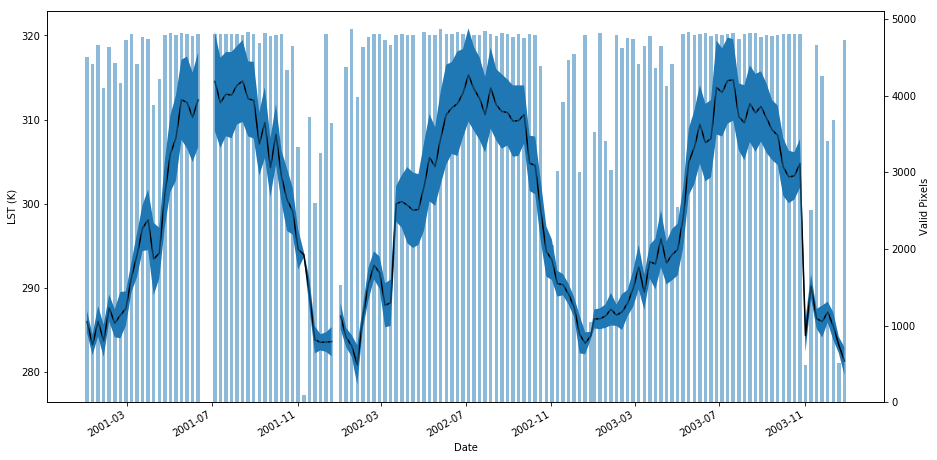

In [17]:
plt.rcParams['figure.figsize'] = (15,8)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('LST (K)')
ax1.plot(lststats.index, lststats['mean'], 'k-')
ax1.fill_between(lststats.index, lststats['mean']-lststats['sd'], lststats['mean']+lststats['sd'])
ax1.tick_params(axis='y')
fig.autofmt_xdate()

ax2 = ax1.twinx()
ax2.set_ylabel('Valid Pixels')
ax2.bar(lststats.index, lststats['quality'], 5, alpha = 0.5)
ax2.tick_params(axis='y')

plt.show()